# Tutorial: processing scanning 3DXRD data using Friedel Pairs 
## Introduction

scanning 3-dimensional X-ray Diffraction (s3DXRD), or point-focused High Energy Diffraction Microscopy(pf-HEDM) if you prefer is a variation of the 3DXRD/HEDM technique (Poulsen, 2004) to map crystallographic orientation and strain within a 3D volume. It uses a pencil-beam setup, where the sample is translated and rotated multiple times in order to successively illuminate different sub-volume of the sample with the incident beam. Although the acquisition time is significantly increased compared to regular 3DXRD/HEDM with a larger line-focus or box beam, s3DXRd provides much richer information on the internal crystal orientation and strain field. It allows complete reconstruction of the grain shapes, and theoretically allows to map intra grain variations of orientation and strain. However, processing 3DXRD data can be long and tedious, and the "normal" procedure involving grain fitting and reconstruction from the sinogram of data can appear somewhat non-intuitive to the novice. 

An alternative procedure has been developped (Jacob et al., submitted), which exploits the symmetric properties of Friedel pairs to process s3DXRD datasets. Friedel pairs are symmetric reflections (h,k,l) and (-h,-k,-l) arising from the same grain, which occur at 180° offset during a full 360° rotation of the sample along an axis perpendicular to the beam. Using the symmetric properties of these pairs, it is possible to clearly seperate the component of the apparent diffraction vectors related to lattice orientation and spacing (the "true" diffraction vector) from the component related to spatial offset from the rotation centre (which provides information on the position of the diffracting source in the sample). Identifying Friedel pairs in a 3DXRD dataset thus enables to treat indexing and grain position fitting as two independant problems, which considerably simplifies data analysis, in particular in complex samples such as polyphased, highly strained polycrystaline materials. 


This tutorial aims to guide you step-by-step to obtain an indexed grain map starting from segmented diffraction peaks, using the Friedel pair method. More detailed information about the method can be found in the associated publication (Jacob et al. submitted). 


#### Requirements:

##### Software
- a functional python environment (3.9 or above) installed on your machine, with jupyter notebooks. If you use the ESRF Nice cluster, it should be allright
- ImageD11 module to process 3D X-ray diffraction data. Check here for details on installation:  https://github.com/FABLE-3DXRD/ImageD11 

#### Data acquisition & pre-processsing
- data acquisition must be done applying full 360° rotations of the sample along the z-axis (vertical), in order to get symmetric (h,k,l) and (-h,-k,-l) reflections. Regular 180° scans are not suitable for the Friedle Pairs technique.
- the raw diffraction frames have been segmented into discrete diffraction peaks and stored in a peak table (check the notebook 0S3DXRD_segment_and_label.ipynb here: https://github.com/FABLE-3DXRD/ImageD11/tree/master/ImageD11/nbGui/S3DXRD).
- A dataset file (ImageD11.sinograms.dataset) containing information about range and step size of scanning (ystep, ybins, obins, etc.) has been computed
- detector has been properly calibrated, with calibration parameters (tilt, center, distance, etc.) stored in a ImageD11 parameter file (*.par)


#### Example dataset
Example datasets are provided in the folder /data

SI3_DT360Z5480 is a slice of granite scanned at the 3DXRD station of ID11 (ESRF), using a 50x50 µm pencil beam and angular steps of 0.8°. It contains a diverse mineral assemblage consisting of quartz, biotite, orthoclase (K-feldspar), oligoclase (Plagioclase) and magnetite. Peak segmentation was done using old, deprecated code and has no peak table assigned, so only a peakfile (ImageD11 columnfile saved in hdf format) is provided. This dataset is relatively small and it should be possible to process it on a personal machine without crashing. For large high-resolution datasets, access to a computer cluster with >100 GB active memory is probably necessary.

The dataset SI3_DT360Z5480 includes: 
- a peakfile containing 3D peaks (merged in omega): SI3_DT360Z5480_pk3d.h5
- metadata stored in an ImageD11.sinogram.dataset object: SI3_DT360Z5480_ds.h5 
- a parameter file containing detector calibration parameters: SI3.par
In addition, crystal structures for all the minerals mentioned above are provided as cif files in the /cif folder.

other datasets to come (to show how to process data starting from a peaktable)...


## Summary
This tutorial is divided into five parts, corresponding to different notebooks:

- Tuto_001_Friedel_Pairs_Match.ipynb: Find Friedel pairs in a set of segmented peaks, assign them a label and store the paired peaks in a new ImageD11 columnfile

- Tuto_002_Phase_Labelling.ipynb: Point-by-point phase labeling. Map peaks to pixels on a 2D map and find the best-matching phase for each pixel, from a list of pre-determined crystal structures. Also filter peaks in the peakfile and assign the a phase label.

- Tuto_003_Local_Indexing.ipynb: Point-by-point fitting of the real-space lattice vectors ($UBI$ matrix) on each pixel of the map

- 004_DBSCAN_GrainMapping: A simple grain-mapping strategy using the DBscan algorithm to find grains by clustering pixels in symmetry-reduced orientation space. Inspired from orix (https://orix.readthedocs.io/en/latest/tutorials/clustering_across_fundamental_region_boundaries.html). Read Johnstone et al. 2020 (https://arxiv.org/abs/2001.02716) for more details.

- Tuto_005_Strain_Stress_Mapping.ipynb: Map strain and stress to pixels and grains


In addition, shorter notebooks (without the 'Tuto' prefix) are provided, with less detailed explanation. They aim to serve as a starting base to build your processing workflow.

# Part 1: Friedel Pairs Matching

The first part of the process consists in finding friedel pairs among the set of segmented diffraction peaks. Each pair will be given a unique label, so they can be rapidly identified in subsequent steps. 

### load packages

In [2]:
# general modules
import os, sys
import h5py
import pylab as pl
import numpy as np

# ImageD11 https://github.com/FABLE-3DXRD/ImageD11
import ImageD11.sinograms.dataset
import ImageD11.sinograms.properties
import ImageD11.sparseframe
import ImageD11.blobcorrector
import ImageD11.columnfile


# point-fit 3dxrd module available at https://github.com/jbjacob94/pf_3dxrd.
# Not yet installable with pip, just copy + paste the files into your working folder 
if '/home/esrf/jean1994b/' not in sys.path:
    sys.path.append('/home/esrf/jean1994b/')
    
from pf_3dxrd import utils, friedel_pairs, crystal_structure

%matplotlib ipympl
%load_ext autoreload
%autoreload 2

### Loading data
Recent dataset acquired at ID11 should consist in a peak table (*_peaks_table.h5) containing 2D peaks segmented from 2D diffraction frames, 3D peaks merged in omega, and labels to relate 2D peaks to 3D peaks ("spot3D_id"). Metadata with file paths, rotation and translation steps, etc. are stored in a "Dataset" file (*_ds.h5). For dataset SI3_DT360Z5480, 3D spots are directly provided as an ImageD11 columnfile. If you wish to start your processing from a ImageD11 columnfile, this can be precised in the load_data function (input_format = 'peakfile').

The first step consists in loading these data and storing peaks in a columnfile. 

#### should I use 2D or 3D peaks?
2D peaks are raw peaks segmented from the 2D detector image, while 3D peaks are 2D peaks merged in omega. Friedel pair search can be done on both. In my experience, working with 2D peaks provides better results for the point-by-point fit of orientations, especially for large grains with low misorientation. However, it is at the expense of (much) larger memory requirement and longer computation time than merged 3D peaks, because the number of peaks to match is much larger. For the SI3_DT360Z5480 dataset in this tutorial, only 3D peaks are available.

In [4]:
def load_data(dsname, parfile, input_format = 'peaktable', detector = 'eiger', return_2D_peaks=False):
    """ 
    load data from peakfile or peaktable 
    
    Args:
    ----------
    dsname (str) : dataset name
    parfile (str): parameter file name
    input_format (str) : either 'peaktable' or 'peakfile'. Control whether data is loaded from an ImageD11 peak table or from a simple peakfile 
    detector (str) : detector type used for data acquisition. eiger or frelon. Default if eiger (nanofocus station at ID11)
    return_2D_peaks (bool): returns 2D peaks instead of 3D peaks (merged in omega) are returned. Only relevant for data loaded from a peak table
                            default is False
    
    Returns:
    cf : ImageD11 columnfile
    ds : ImageD11 dataset
    """
    ####################################
    assert input_format in ['peakfile', 'peaktable'], 'input_format must be either "peakfile" or "peaktable" '
    assert detector in ['eiger', 'frelon'], 'input_format must be either "eiger" or "frelon" '
    
    # paths
    ####################################
    if input_format == 'peaktable':
        pksfile = os.path.join(data_dir, dsname+'_peaks_table.h5')
        dsfile  = pksfile.replace('peaks_table','ds')
    else:
        pksfile = os.path.join(data_dir, dsname+'_pks.h5') 
        dsfile  = pksfile.replace('pks','ds')
   
    
    # load ds file and peaks dictionary
    ####################################
    ds = ImageD11.sinograms.dataset.load(dsfile)

    print(f'Loading data for dataset {ds.dsname}: \n==============================')    
    items = 'n_ystep,n_ostep,ymin,ymax,ystep,omin,omax,ostep'.split(',')
    vals  = [ds.shape[0], ds.shape[1], ds.ymin, ds.ymax, ds.ystep, ds.omin, ds.omax, ds.ostep]
    for i,j in zip(items, vals):
        print(f'{i}: {j:.1f}')
        
    print('==============================')
        
    if input_format == 'peakfile':
        print('loading peakfile...')
        pks = ImageD11.columnfile.columnfile(pksfile)
        pkd = {t:pks.getcolumn(t) for t in pks.titles}
         
    else:
        print('loading peaks from peak table...')
        pkst = ImageD11.sinograms.properties.pks_table.load(pksfile)
        
        print('merging peaks...')
        if return_2D_peaks:      
            pkd = pkst.pk2d( ds.omega, ds.dty )         # for 2D peaks
        else:
            pkd = pkst.pk2dmerge( ds.omega, ds.dty )  # for 3D peaks
            
    cf = ImageD11.columnfile.colfile_from_dict(pkd)
    print(f'loaded peakfile: nrows = {cf.nrows}')
    utils.get_colf_size(cf)
    
    return cf, ds


In [14]:
# define paths
data_dir = 'data'

dsname = 'SI3_DT360Z5480'
parfile='data/SI3.par'
splinefile = 'data/frelon21_mar16.spline'


# load data
cf, ds = load_data(dsname, parfile, input_format='peakfile', detector='frelon')

print(cf.titles)

Loading data for dataset SI3_DT360Z5480: 
n_ystep: 109.0
n_ostep: 450.0
ymin: -2.7
ymax: 2.7
ystep: 0.1
omin: 0.0
omax: 360.0
ostep: 0.8
loading peakfile...
Reading your columnfile in hdf format
loaded peakfile: nrows = 4104546
Total size =  109.60 MB
['omega', 's_raw', 'f_raw', 'sum_intensity', 'spot3d_id', 'dty', 'number_of_pixels']


### Distortion correction

cf contains raw data columns f_raw and s_raw with raw peak coordinates. These coordinates need to be corrected for detector distortion. Different methods exist depending on the detector used for data acquisition. For the eiger detector of ID11 (nf workstation), pre-computed distorsion images (dxfile, dyfiles) are provided, which allow fast distortion correction. For the frelon detector (3DXRD station), a splinefile is provided, from which a pixel lookup table is made, which gives the (dx,dy) correction for each pixel. 

In [15]:
def correct_distorsion_eiger( cf, parfile,
              dxfile="/data/id11/nanoscope/Eiger/spatial_20210415_JW/e2dx.edf",
              dyfile="/data/id11/nanoscope/Eiger/spatial_20210415_JW/e2dy.edf"):
    
    """ 
    FOR EIGER DATA. Apply detector distortion correction for eiger data, using pre-computed disortion files. 
    Adds on the geometric computations (tth, eta, gvector, etc.)
    
    Args: 
    ---------
    cf : ImageD11 columnfile
    parfile (str) : parameter file
    dxfile, dyfile : detector distortion. Default files are valid for the eiger detector on the nanofocus station at ID11 
    """
    
    spat = ImageD11.blobcorrector.eiger_spatial( dxfile = dxfile, dyfile = dyfile )
    cf = ImageD11.columnfile.colfile_from_dict( spat( {t:cf.getcolumn(t) for t in cf.titles()} ) )
    cf.parameters.loadparameters(parfile)
    cf.updateGeometry()
    return cf


def correct_disorsion_frelon( cf, parfile, splinefile, detector_dim = [2048,2048]):
    """ 
    FOR FRELON DATA. Apply detector distortion correction using a pixel look up table computed from a splinefile. 
    Adds on the geometric computations (tth, eta, gvector, etc.)
    
    Args: 
    ---------
    cf : ImageD11 columnfile
    parfile (str) : parameter file
    splinefile    : detector distortion splinefile
    detector_dim  : (X,Y) detector dimensions  
    """
    
    spat = ImageD11.blobcorrector.correctorclass(splinefile)
    
    # make pixel_lut  + substract xy grid coordinate (i,j) to keep only dx and dy arrays.
    spat.make_pixel_lut((detector_dim[0], detector_dim[1]))
    i, j = np.mgrid[ 0:detector_dim[0], 0:detector_dim[1] ]
    dx = spat.pixel_lut[0] - i
    dy = spat.pixel_lut[1] - j
    
    # get integer pixel index (si,fi) of each peak
    si = np.round(cf['s_raw']).astype(int)
    fi = np.round(cf['f_raw']).astype(int)
    
    # apply dx dy correction on s_raw / f_raw
    sc = (dx[ si, fi ] + cf.s_raw).astype(np.float32)
    fc = (dy[ si, fi ] + cf.f_raw).astype(np.float32)
    
    # add corrected arrays as new columns
    cf.addcolumn(sc, 'sc')
    cf.addcolumn(fc, 'fc')
    
    # load parameters and update geometry
    cf.parameters.loadparameters(parfile)
    cf.updateGeometry()
    
    return cf

In [16]:
# detector correction distorsion with frelon data
cf = correct_disorsion_frelon( cf, parfile, splinefile, detector_dim = [2048,2048])


# detector correction distorsion with eiger data
#cf = correct_distorsion_eiger(cf, parfile)

cf.titles

['omega',
 's_raw',
 'f_raw',
 'sum_intensity',
 'spot3d_id',
 'dty',
 'number_of_pixels',
 'sc',
 'fc',
 'xl',
 'yl',
 'zl',
 'tth',
 'eta',
 'gx',
 'gy',
 'gz',
 'ds']

Now, a bunch of new columns have appeared. sc, fc are corrected peak coordinates on the 2D detector. All other new columns contain diffraction vectors computed in different geometries:
- (xl,yl,zl) correspond to diffraction vector coordinates in the Cartesian laboratory reference frame
- (tth, eta) correspond to diffraction angles two-theta and eta (related to radial and azimuthal coordinates on the detector)
- (gx, gy, gz) correspond to coordinates of reciprocal lattice vectors 

### Pre-processing
Before looking for Friedel pairs, we will clean up a bit the peakfile to remove weak peaks. 

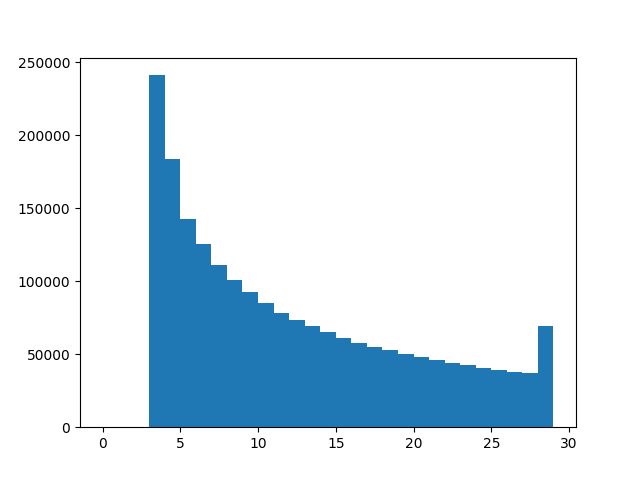

In [19]:
# look at distribution of peak intensity + nb of pixels to decide what threshold to apply
pl.figure()
pl.hist(cf.number_of_pixels,bins=np.arange(30));

In [21]:
# filter data
cf.filter(cf.sum_intensity>100)
cf.filter(cf.number_of_pixels>3)   # column title might be 'Number_of_pixels' depending on the detector

cf.nrows

3863533

Friedel pairs match is found between peaks from symmetric scans (+dty;-dty) acquired at equal distance from the rotation center. We first need to form pairs of dty scans and check data is ok

In [22]:
# form dty pairs: pairs of (dty,-dty) scans which should contain symmetric information
friedel_pairs.form_y_pairs(cf, ds, disp=True)

dty_center =  -0.00  on bin n° 54
dty pairs: 
-0.0000 ; -0.0000
0.0500 ; -0.0500
0.1000 ; -0.1000
0.1500 ; -0.1500
0.2000 ; -0.2000
0.2500 ; -0.2500
0.3000 ; -0.3000
0.3500 ; -0.3500
0.4000 ; -0.4000
0.4500 ; -0.4500
0.5000 ; -0.5000
0.5500 ; -0.5500
0.6000 ; -0.6000
0.6500 ; -0.6500
0.7000 ; -0.7000
0.7500 ; -0.7500
0.8000 ; -0.8000
0.8500 ; -0.8500
0.9000 ; -0.9000
0.9500 ; -0.9500
1.0000 ; -1.0000
1.0500 ; -1.0500
1.1000 ; -1.1000
1.1500 ; -1.1500
1.2000 ; -1.2000
1.2500 ; -1.2500
1.3000 ; -1.3000
1.3500 ; -1.3500
1.4000 ; -1.4000
1.4500 ; -1.4500
1.5000 ; -1.5000
1.5500 ; -1.5500
1.6000 ; -1.6000
1.6500 ; -1.6500
1.7000 ; -1.7000
1.7500 ; -1.7500
1.8000 ; -1.8000
1.8500 ; -1.8500
1.9000 ; -1.9000
1.9500 ; -1.9500
2.0000 ; -2.0000
2.0500 ; -2.0500
2.1000 ; -2.1000
2.1500 ; -2.1500
2.2000 ; -2.2000
2.2500 ; -2.2500
2.3000 ; -2.3000
2.3500 ; -2.3500
2.4000 ; -2.4000
2.4500 ; -2.4500
2.5000 ; -2.5000
2.5500 ; -2.5500
2.6000 ; -2.6000
2.6500 ; -2.6500
2.7000 ; -2.7000


dty pairs should have roughly the same number of peaks assigned. If not, there are two possible explanations:

- the sample is not very well aligned on the rotation center. This is not a big deal, you will just need to crop out the data after pairing, and loose some part of the outer part of the sample. 
- the sample has moved during scanning. This is more problematic, because it means that symmetric (dty, -dty) scans are decorrelated, and peaks match won't be very reliable.   


100%|██████████| 55/55 [00:00<00:00, 134.49it/s]


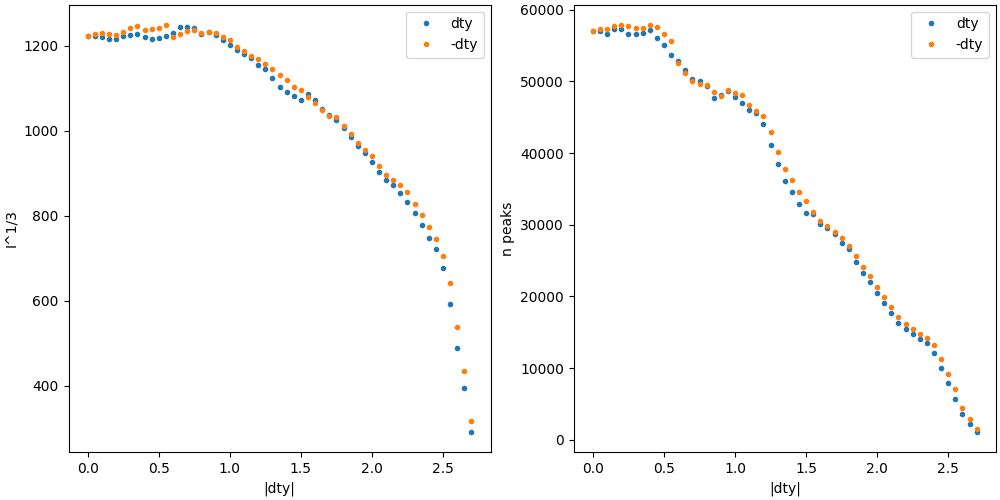

In [23]:
# check dty pairs have roughly the same number of peaks assigned. If not, there is maybe a problem
friedel_pairs.check_y_symmetry(cf, ds, saveplot=False)

For SI3_DT360Z5480, the number of peaks and total intensity match very well in each pair of scans. We also see that the total intensity and number of peaks per scan is decreasing with increasing distance from the rotation center (dty=0). This is normal, because the volume illuminated by the beam decreases toward the rim and eventially reaches zero when the beam is fully out of the sample. 

### Friedel pair labeling

Now we are ready for pairing. We can first try on one pair of scans, to see how it looks and tune parameters for the Friedel pair matching function. This is done using the function label_friedel_pair from the friedel_pair module. This function searches for nearest neighbors between two symmetric scans. Multiple iterations of this process are run, applying an increasigly large distance threshold to identify nearest neighbors. 

The two paremters dist_max and dist_step control the distance threshold applied for nearest-neighbor search. At each iteration, the distance threshold is increased of dist_step, until the value dist_max is reached. This distance is expressed in a 4D space formed using two-theta, eta, omega, intensity, each rescaled and normalized to a value between 0 and 1.

Setting doplot = True, several plots are made to evaluate the quality of pairs match.


6972 pairs kept out of  7781  possible matches
12490 pairs kept out of  17931  possible matches
13234 pairs kept out of  25287  possible matches
9306 pairs kept out of  21317  possible matches
5370 pairs kept out of  12824  possible matches
3050 pairs kept out of  6926  possible matches
1839 pairs kept out of  3981  possible matches
1011 pairs kept out of  2239  possible matches
595 pairs kept out of  1260  possible matches
394 pairs kept out of  761  possible matches
Friedel pair matching Completed.
N pairs = 54261 out of 57045 possible candidates
Fraction of peaks matched = 0.95
Fraction of intensity matched = 0.94
dstep_max = 0.100


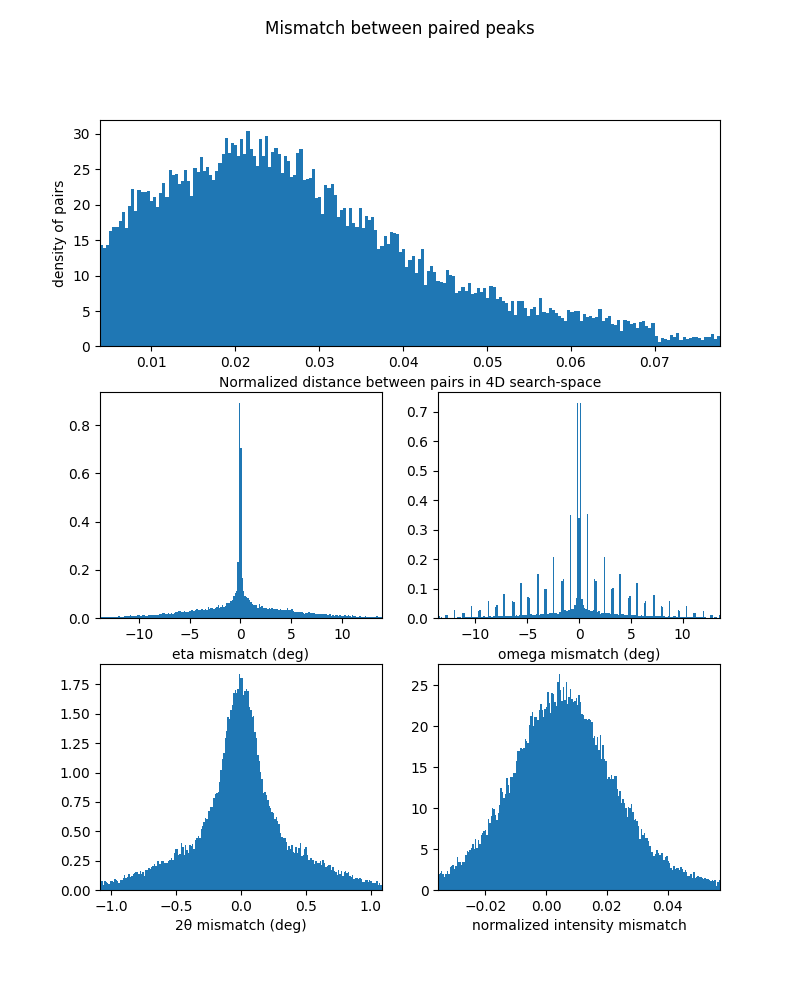

In [24]:
# select peaks from a pair
c1, c2 = friedel_pairs.select_ypair(cf, ds, pair_id = 0)

# friedel pair search. let's try first with these values
cp = friedel_pairs.label_friedel_pairs(c1,c2,
                                  dist_max = .1,
                                  dist_step = 0.01,
                                  verbose=True,
                                  doplot=True)

Let's have a look at output stats. With SI3_DT360Z5480, a large proportion of peaks have been paired: 95%, corresponding to 94% of total intensity. Great! The different plots show the distribution of peak mismatch along the four dimensions used to build the 4D search space: eta mismatch (degree), omega mismatch (degree), two-theta mismatch (degree), and intensity mismatch (normalized intensity value) 


Mismatch in two-thet and intensity is usually pretty small. Some peaks have a relatively large mismatch in eta and/or omega, and correspond likely to dodgy pairs. We can reduce a bit the dist_max threshold to try to filter out some of these pairs. At this stage, it is however not critical if there is a small proportion of dodgy pairs in the dataset.

1932 pairs kept out of  1974  possible matches
5051 pairs kept out of  5540  possible matches
5893 pairs kept out of  6855  possible matches
6796 pairs kept out of  8367  possible matches
7172 pairs kept out of  9497  possible matches
6447 pairs kept out of  8954  possible matches
5198 pairs kept out of  7491  possible matches
4120 pairs kept out of  6065  possible matches
2919 pairs kept out of  4309  possible matches
2188 pairs kept out of  3180  possible matches
1652 pairs kept out of  2392  possible matches
1226 pairs kept out of  1728  possible matches
1040 pairs kept out of  1452  possible matches
704 pairs kept out of  990  possible matches
651 pairs kept out of  1043  possible matches
348 pairs kept out of  466  possible matches
Friedel pair matching Completed.
N pairs = 53337 out of 57045 possible candidates
Fraction of peaks matched = 0.93
Fraction of intensity matched = 0.92
dstep_max = 0.080


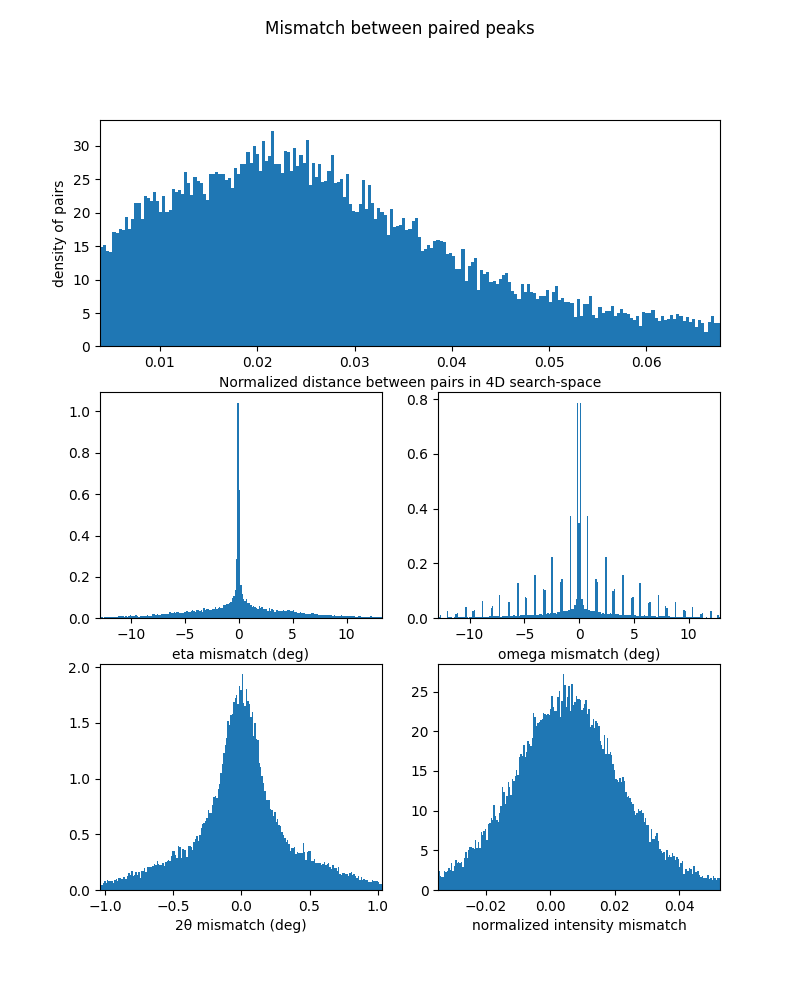

In [33]:
c1, c2 = friedel_pairs.select_ypair(cf, ds, pair_id = 0)

cp = friedel_pairs.label_friedel_pairs(c1,
                                  c2,
                                  dist_max = .08,
                                  dist_step = 0.005,
                                  verbose=True,
                                  doplot=True)

Once we are satisfied with the distanc eparameters, we can do the pairing on all y-pairs. For this, we will use the function find_all_pairs, which iterates label_friedel_pairs on all y-pairs in the dataset and then merges all outputs in a single columnfile

In [35]:
cf_paired, fp_labels, stats = friedel_pairs.find_all_pairs(cf,
                                                    ds,
                                                    dist_max=.08,
                                                    dist_step=0.005,
                                                    verbose=True,
                                                    doplot=False)

Friedel pair search...


100%|██████████| 55/55 [01:10<00:00,  1.29s/it]


Friedel pair search completed.
Updating new Friedel pair labels
Merging peakfiles...


100%|██████████| 54/54 [00:03<00:00, 17.42it/s]

Friedel pair matching Completed.
N pairs =  1778732
Fraction of peaks matched = 0.92
Fraction of total intensity matched = 0.87


NB: stats returns the proportion of peaks / total intensity which has been paired. These values are already displayed if verbose is set to True

Now, let's have a look at the new peakfile. It contains two new columns fp_id and fp_dist, which contain respectively the labels of the Friedel pairs, and the 4D distance in (tth,eta,omega,Intensity) between the two peaks of each pair.

In [38]:
cf_paired.titles

['omega',
 's_raw',
 'f_raw',
 'sum_intensity',
 'spot3d_id',
 'dty',
 'number_of_pixels',
 'sc',
 'fc',
 'xl',
 'yl',
 'zl',
 'tth',
 'eta',
 'gx',
 'gy',
 'gz',
 'ds',
 'fp_id',
 'fp_dist']

We can also see that columns in cf have been ordered by fp_id. Each unique value in cf.fp_id occurs exactly twice, corresponding to the two peaks in each pair. If you want to select one peak of each Friedel pair, you can simply select all odd or even indices in a column. e.g. cf_paired.tth[::2] / cf_paired[1::2]

In [45]:
# show the first 10 pairs
for t in ['fp_id', 'tth', 'sum_intensity']:
    v = cf_paired.getcolumn(t)[:20]
    print(f'{t}:\n {v}')

np.all(np.equal(cf_paired.fp_id[::2], cf_paired.fp_id[1::2]))

fp_id:
 [0 0 1 1 2 2 3 3 4 4 5 5 6 6 7 7 8 8 9 9]
tth:
 [11.80819846 11.9209668   2.9018827   2.90309904  9.58684546  9.51330935
 11.65277021 11.55217699  9.8763128   9.89431439 14.21002717 14.10915324
 13.63648595 13.571783   14.0507914  13.92463881  8.0738745   8.16511978
  7.17136208  7.12195618]
sum_intensity:
 [ 3258.5  3188.5   794.    764.   7922.5  7593.  35928.5 35273.5  2132.
  2180.  20835.  21482.5  3004.   3140.5  1105.   1082.  17384.5 17916.
  8785.5  9046. ]


True

There is also a function to split the columnfile into two symmetrical columnfiles containing one peak of each pair

In [46]:
c1, c2 = friedel_pairs.split_fpairs(cf_paired)
print(f'c1: {c1.fp_id[:10]}')
print(f'c2: {c2.fp_id[:10]}')

c1: [0 1 2 3 4 5 6 7 8 9]
c2: [0 1 2 3 4 5 6 7 8 9]


We can also plot the distribution of distance in the 4D search space to see how it looks

Text(0.5, 0, '4D distance between pairs')

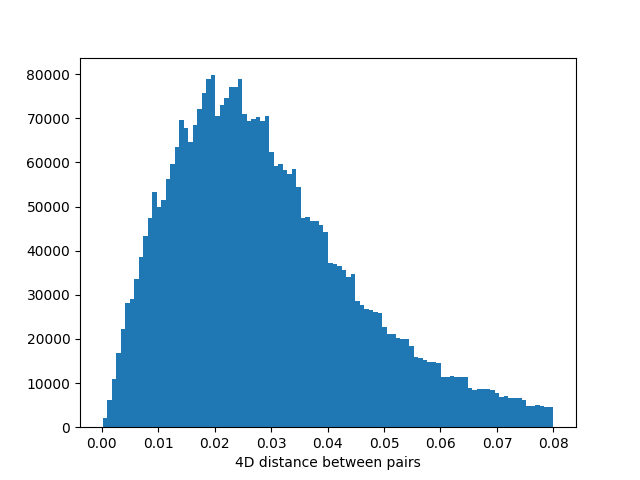

In [48]:
pl.figure()
pl.hist(cf_paired.fp_dist,100);
pl.xlabel('4D distance between pairs')

Typically, the distribution of 4D distance show an asymetric shape, with a maximum close to zero and a long tail toward higher values. Ideally, you want the peak of the distribution to be as close as possible from zero, with a sharp decrease of the tail at increasing distance. Flattish distributions peaking far from zero and showing a smooth decrease toward higher distance are likely dodgy. 

For SI3_DT360Z5480, the distribution looks pretty good. We cut off the tail for fp_dist > 0.08, which probably contains mostly dodgy values.

Note however that there are no canonical rules to discriminate a "good" from a "bad" distribution. Distance is likely to change significantly depending on the sample size. The figures shown here work well for sampe SI3_DT360Z5480, which is about 5mm wide. For a smaller or larger sample, it might be different because the two-theta offset will be different. 

We can also plot the mismatch in two-theta, eta, etc.

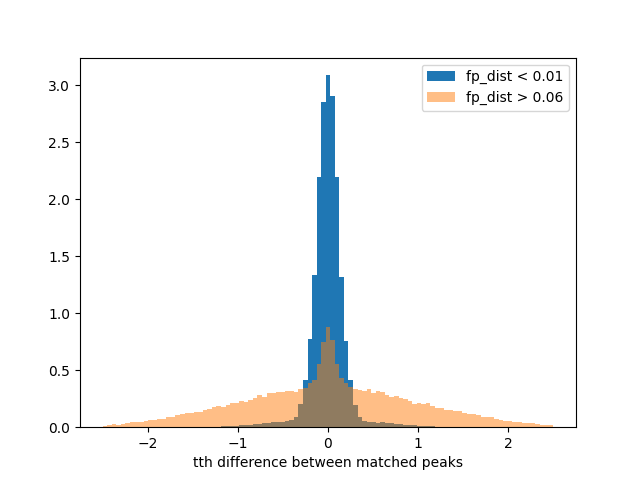

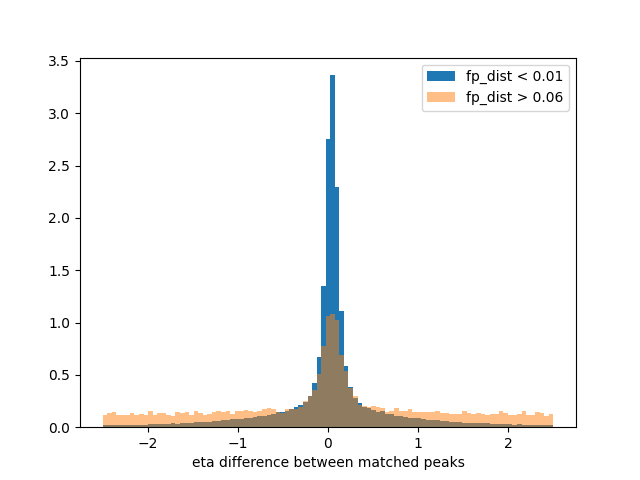

In [50]:
c1, c2 = friedel_pairs.split_fpairs(cf_paired)
dlow, dhigh = 0.01, 0.06
m = c1.fp_dist < dlow
m2 = c1.fp_dist > dhigh

pl.figure()
pl.hist(c1.tth[m] - (c2.tth[m]),bins=np.linspace(-2.5,2.5,100), density=True, label=f'fp_dist < {dlow}');
pl.hist(c1.tth[m2] - (c2.tth[m2]),bins=np.linspace(-2.5,2.5,100), alpha=.5, density=True, label = f'fp_dist > {dhigh}');
pl.xlabel('tth difference between matched peaks')
pl.legend()

pl.figure()
pl.hist(c1.eta[m]%360 - (180-c2.eta[m])%360,bins=np.linspace(-2.5,2.5,100), density=True, label=f'fp_dist < {dlow}');
pl.hist(c1.eta[m2]%360 - (180-c2.eta[m2])%360,bins=np.linspace(-2.5,2.5,100), alpha=.5, density=True, label = f'fp_dist > {dhigh}');
pl.xlabel('eta difference between matched peaks')
pl.legend()

We see that large fp_dist corresponds mostly to pairs with unrealistic 2-theta mismatch. However, the large fp_dist subset also contains some "good" peaks, so in the end, there is a tradeoff when filtering out peaks with large fp_dist: if the threshold is large, you keep most of the good pairs, but include a large proportion of dodgy ones. If the threshold is too low, you remove most of the dodgy pairs, but also loos a good share of correct ones. 

### Geometry correction
Now we have friedel pairs labeled, we can start doing useful stuff with them!

If a grain is not on the rotation centre but translated by an offset $t(d_x, d_y, d_z)$ from the center, this will result in an offset on the detector and inaccurate 2-theta and eta values. In a classic indexing procedure, $t$, eta and 2-theta are fitted *à-posteriori*, after a first round of indexing. With Friedel pairs, we can do this before, which will make indexing much easier.

For scanning 3DXRD acquisition using a thin pencil beam, the beam dimension in y and z is small. Therefore, we can consider that offset only occurs along the beam direction, ie. along the x-axis. This means that only 2-theta (tth) is modified by this offset, not eta. We also know $d_y$, which is basically the translation along the y-direction during scanning, which is stored in the dty column. With these assumptions, we find that for two peaks (p1,p2) forming a Friedel pair:

- $2θ_{cor}$ = 1/2.(tan1 + tan2)
- $d_x$ = L * (tan1-tan2)/(tan1+tan2)

where tan1 and tan2 are respectively tan($2θ_1$) and tan($2θ_2$) of p1 and p2 and L the detector distance from the rotation center. Thus, we get $2θ_{cor}$, the "real" scattering angle accounting only for d-spacing in the crystal and not the for offset from the rotation centre.

$d_x$ and $d_y$ need to be back-rotated of an angle omega in order to put them in the sample reference frame, and give the position $(x_s,y_s)$ of the grain in the sample, wich will then be used for point-by-point fit.

These geometric corrections are done using the function update_geometry_s3dxrd from the friedel_pairs module.

In [51]:
friedel_pairs.update_geometry_s3dxrd(cf_paired, detector = 'frelon', update_gvecs=True) 
cf_paired.titles

['omega',
 's_raw',
 'f_raw',
 'sum_intensity',
 'spot3d_id',
 'dty',
 'number_of_pixels',
 'sc',
 'fc',
 'xl',
 'yl',
 'zl',
 'tth',
 'eta',
 'gx',
 'gy',
 'gz',
 'ds',
 'fp_id',
 'fp_dist',
 'tthc',
 'dsc',
 'xs',
 'ys',
 'r_dist']

New columns have been computed:
- tthc: corrected two-theta
- dsc: corrected d-spacing (in Å-1)
- r_dist: radial distance of the diffracting source from the rotation center
- (xs,ys): diffracting source position in the reference frame of the sample

Now let's have a look on the data. We can first try to compare 2-theta before and after correction

Text(0, 0.5, 'pdf')

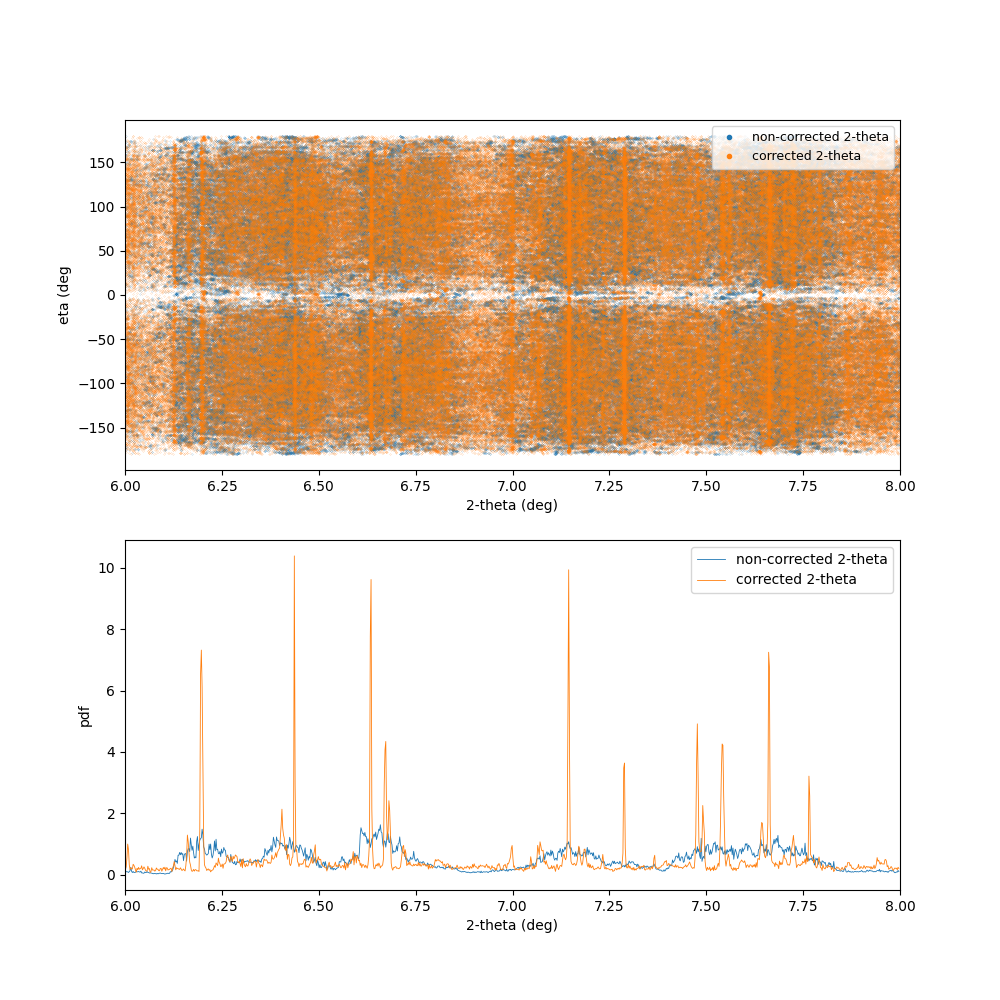

In [52]:
# plot 2-theta vs. eta for corrected vs non-corrected tth on a subset of the two-theta range
tthmin, tthmax = 6,8

fig = pl.figure(figsize=(10,10))
fig.add_subplot(211)
pl.plot(cf_paired.tth, cf_paired.eta, '.', ms = .2, label='non-corrected 2-theta') 
pl.plot(cf_paired.tthc, cf_paired.eta, '.', ms=.2, label='corrected 2-theta')
pl.xlabel('2-theta (deg)')
pl.ylabel('eta (deg')
pl.xlim(tthmin, tthmax)
pl.legend(markerscale=30, loc='upper right', fontsize=9) 

# 2-theta histogram for corrected vs non-corrected peaks
fig.add_subplot(212)
h,b,_ = utils.compute_tth_histogram(cf_paired, use_tthc = False, tthmin=tthmin, tthmax = tthmax, tthstep = 0.002,
                                    uself = True, doplot=False, density=True)
hc,bc,_ = utils.compute_tth_histogram(cf_paired, use_tthc = True, tthmin=tthmin, tthmax = tthmax, tthstep = 0.002,
                                      uself = True, doplot=False, density=True)

pl.plot(b,h,'-', lw=.6, label='non-corrected 2-theta')
pl.plot(bc,hc,'-',lw=.6, label='corrected 2-theta')
pl.legend()
pl.xlim(tthmin, tthmax)
pl.xlabel('2-theta (deg)')
pl.ylabel('pdf')


#### Comparison with computed hkl rings

There is a sharp reduction of the 2-theta spread using corrected peak coordinates, and we see some peaks appearing in the distribution. Now we want to see if these peaks match with predicted Bragg peaks for the different phases in the sample. 

For this we need to compute the theoretical two-theta position of these peaks for each phase in the sample. This can be done by using ImageD11 functions and loading multiple parameter files. However, this rapidly becomes impractical when the sample contains more than one or to phases.

Instead, we will use the module crystal_structure.py from pf_3dxrd. This module is built upon other python packages for X-ray diffraction data, namely diffpy.structure, Dans_Diffraction and orix. It defines a class CS (for crystal_structure), which allows to store crystal structure information directly loaded from a cif file.

For simplicity, we assume that we already know what are the phases in the sample, and directly provide crystal structures as cif files. However, depending on your sample, some phases might be unknown and need to be determined beforehand. If this is the case, you can use the  the following strategy:
- export the histogram of corrected $2θ$ to an ascii file. 
- import this file in your favorite powder diffraction analysis software, where the two-theta spectrum can be compared to a database of known crystal structures. Once each major phase has been identified, you can try Le Bail or Rietveld refinement to fit more precisely the average lattice parameters. Having a good fit of these lattice parameters is important, because it will determine how accurately you can pick up diffraction peaks from a given crystal structure, using two-theta thresholds around each Bragg peak computed from the fitted unit cell.


In [53]:
# let's define a dictionary with all our phases. l
phase_names = ['quartz', 'orthoclase', 'oligoclase', 'biotite', 'magnetite']
phase_dict = {}

# load crystal structures from cif files. They should all be in the /cif folder
for i,p in enumerate(phase_names):
    cs = crystal_structure.load_CS_from_cif(cif_path = f'cif/{p}.cif', name=p, pid=i)
    print(cs)
    phase_dict[p] = cs

CS: quartz, phase_id: 0, spg: P3221, spg_no: 154, lattice: [4.91325, 4.91325, 5.41206, 90.0, 90.0, 120.0]
CS: orthoclase, phase_id: 1, spg: C1-11, spg_no: 12, lattice: [8.589, 13.013, 7.197, 90.0, 116.02, 90.0]
CS: oligoclase, phase_id: 2, spg: C-1, spg_no: 2, lattice: [8.154, 12.823, 7.139, 94.06, 116.5, 88.59]
CS: biotite, phase_id: 3, spg: C12/m1, spg_no: 12, lattice: [5.355, 9.251, 10.246, 90.0, 100.15, 90.0]
CS: magnetite, phase_id: 4, spg: Fd3m, spg_no: 227, lattice: [8.3965, 8.3965, 8.3965, 90.0, 90.0, 90.0]


We want to compute theoretical 2-theta positions of Bragg peaks for all these phases. It is possible to get directly these values with ImageD11, but we will use a bit more fancy way here, which happens to be quite usefull when dealing with complex mixtures of low-symmetry phases: first, we compute a simulated powder spectrum for each phase. Then, we run a peaksearch on this spectrum (using scipy.signal) to find the N-strongest peaks. This allows to retain only the most significant peaks, and ignore the numerous, very low intensity peaks which theoretically exist but are practically barely visible.

Scatter(quartz with 2 atomic positions, 6 symmetries)
       Type: x-ray
     Energy: 43.57356018082551 keV
 Wavelength: 0.28454050670689945 A
 ---Settings---
      Powder units: tth
    Isotropic ADPs: True
  Specular Direction (reflection): ( 0, 0, 1)
Parallel Direction (transmission): ( 0, 0, 1)
      theta offset: 0.0
         min theta: -180.0
         max theta: 180.0
      min twotheta: 2
      max twotheta: 15
 ---X-Ray Settings---
 Waasmaier scattering factor: False
 ---Magnetic Settings---
   Mag. scattering: True
  Mag. form factor: True
         Polarised: False
      Polarisation: sp
       Pol. vector: (0,1,0)
 ---Resonant Settings---
   Azimuthal angle: 0
    Azimuthal ref.: (1,0,0)
               flm: (0,1,0)
  use e1e1 approx.: True

Scatter(orthoclase with 18 atomic positions, 4 symmetries)
       Type: x-ray
     Energy: 43.57356018082551 keV
 Wavelength: 0.28454050670689945 A
 ---Settings---
      Powder units: tth
    Isotropic ADPs: True
  Specular Direction (refl

/home/esrf/jean1994b/pf_3dxrd/crystal_structure.py:222: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  pl.figure()


Scatter(magnetite with 3 atomic positions, 192 symmetries)
       Type: x-ray
     Energy: 43.57356018082551 keV
 Wavelength: 0.28454050670689945 A
 ---Settings---
      Powder units: tth
    Isotropic ADPs: True
  Specular Direction (reflection): ( 0, 0, 1)
Parallel Direction (transmission): ( 0, 0, 1)
      theta offset: 0.0
         min theta: -180.0
         max theta: 180.0
      min twotheta: 2
      max twotheta: 15
 ---X-Ray Settings---
 Waasmaier scattering factor: False
 ---Magnetic Settings---
   Mag. scattering: True
  Mag. form factor: True
         Polarised: False
      Polarisation: sp
       Pol. vector: (0,1,0)
 ---Resonant Settings---
   Azimuthal angle: 0
    Azimuthal ref.: (1,0,0)
               flm: (0,1,0)
  use e1e1 approx.: True



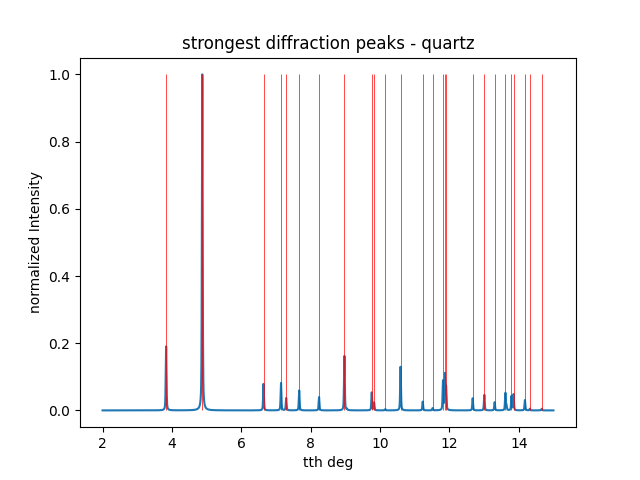

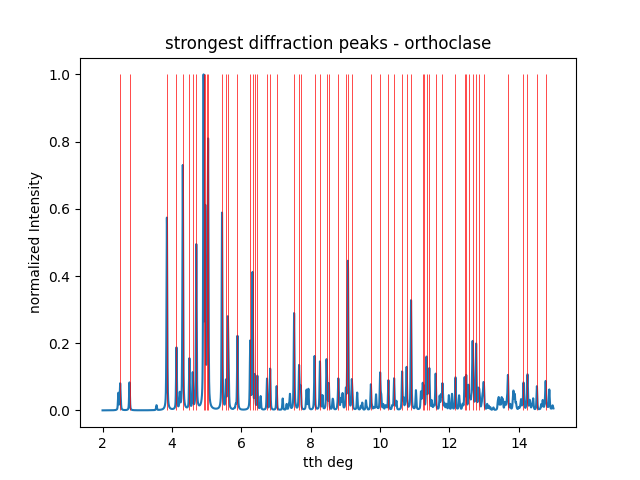

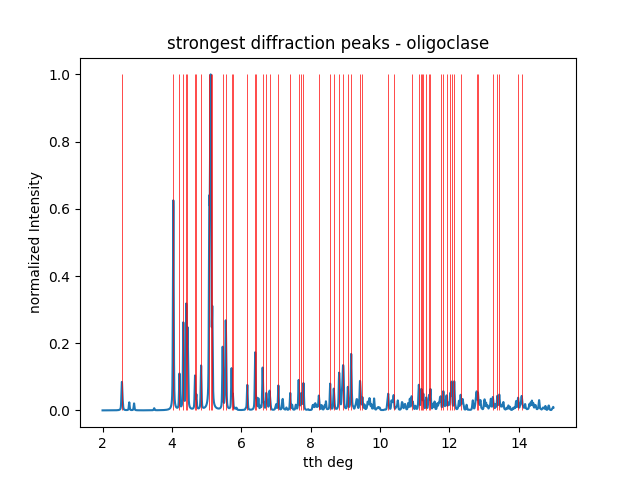

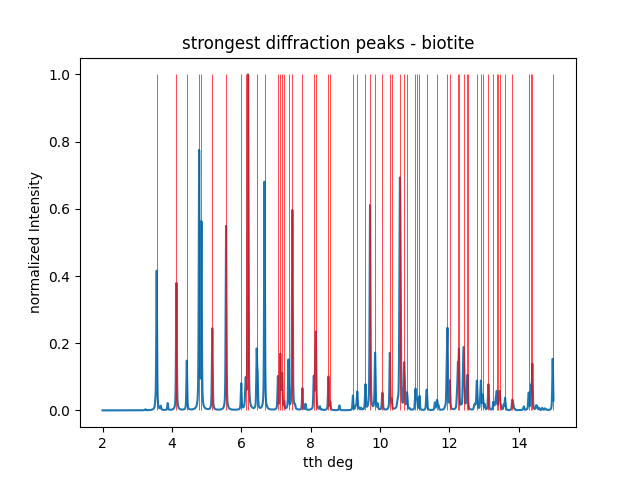

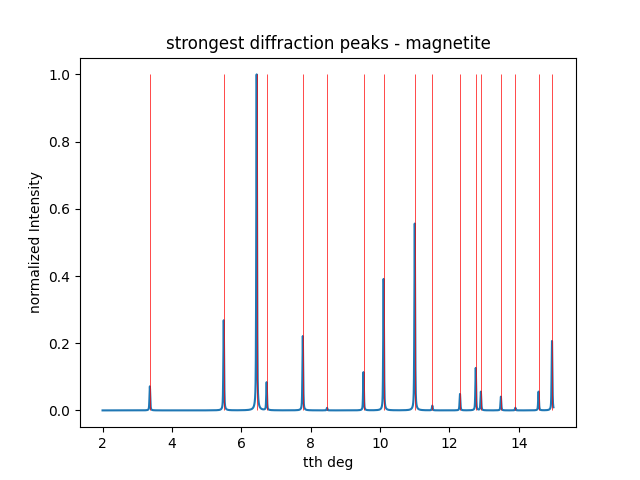

In [54]:
wl = cf.parameters.get('wavelength')  # X-ray wavelength

for cs in phase_dict.values():
    # simulated powder spectrum
    cs.compute_powder_spec(wl, min_tth=2, max_tth=15, doplot=False)
    
    # peak search in the powder spectrum. Imin is the min intensity relative to the strongest peak. 
    # prominence measures how much a peak stands out from the surrounding baseline of the signal (cf scipy.signal)
    cs.find_strongest_peaks(Imin=0.001, prominence=0.001, Nmax=60, doplot=True) 

Now we can replot the data with these theoretical peaks

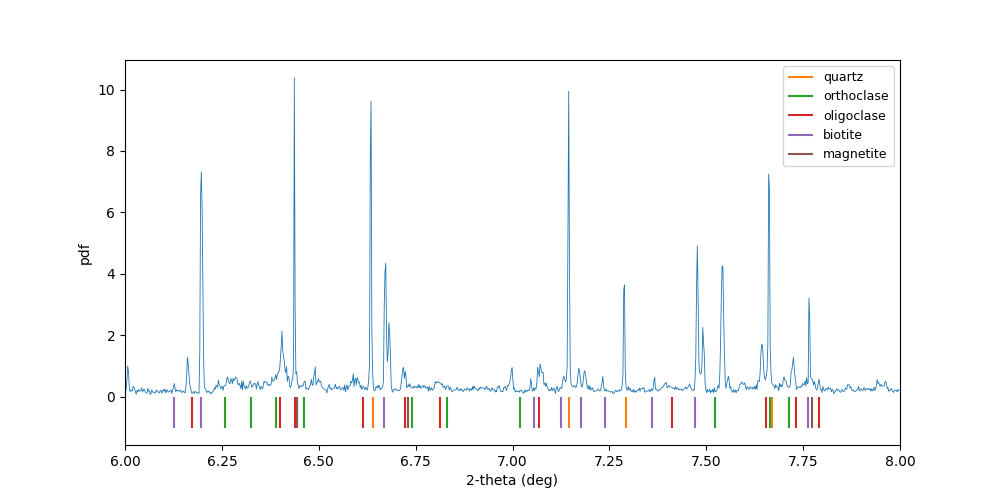

In [55]:
# replot 2θ vs η and add computed hkl ring positions for each phase
colors = pl.matplotlib.cm.tab10.colors

pl.figure(figsize=(10,5))
pl.plot(bc,hc, '-', lw=.6)

for p,cs in phase_dict.items():
    pl.vlines(cs.strong_peaks[0], -1,0, colors = colors[cs.phase_id+1], label=p)
pl.xlabel('2-theta (deg)')
pl.ylabel('pdf')
pl.xlim(tthmin, tthmax)

pl.legend(loc='upper right', fontsize=9) 

The match between theoretical Bragg peaks and real eaks in the distribution looks pretty good, at least for quartz.
There is a slight mismatch especially for orthoclase and oligoclase. These phases are problematic because they are not pure compounds but form solid solutions, with significant variation of the lattice parameters with composition. 

### Sample reconstruction

There is a last thing we can do in this first part of the tutorial. In addition to corrected 2-theta, we also have the $(x_s,y_s)$ coordinates of each diffraction peaks in the sample reference frame. Let's try to plot these data in a 2D histogram

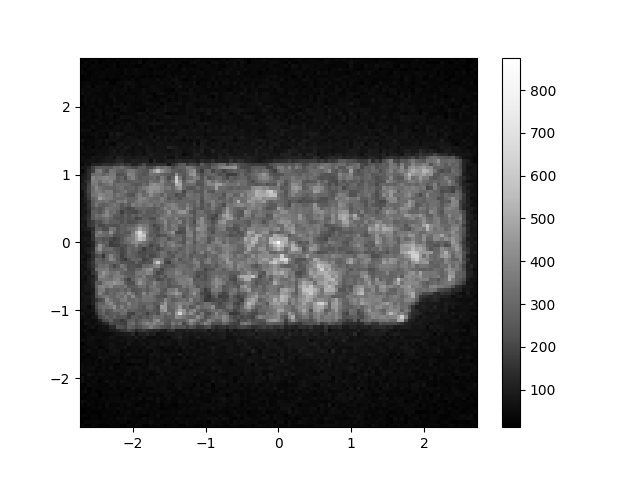

In [56]:
pl.figure()
cmap = pl.matplotlib.cm.Greys_r.copy()
cmap.set_extremes(under='k', over='w')

pl.hist2d(cf_paired.xs, cf_paired.ys, bins = ds.ybinedges, cmap=cmap);
pl.colorbar()

And we get a nice map of the sample! We can filter out peaks outside the ROI, to keep only portions of the map with complete data

In [57]:
cf_paired.filter(cf_paired.r_dist <= ds.ybinedges.max())

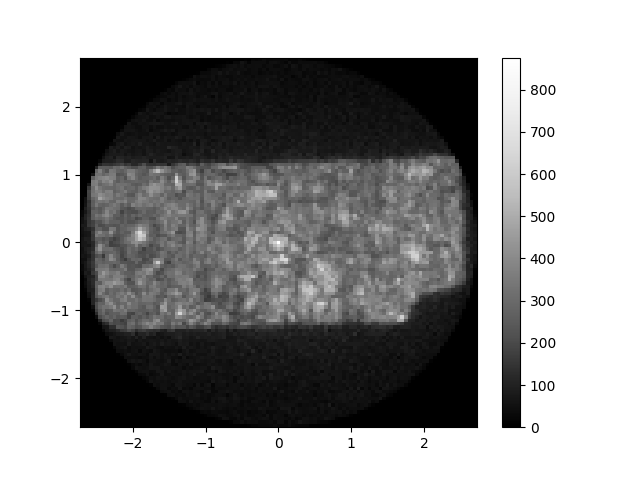

In [58]:
pl.figure()

pl.hist2d(cf_paired.xs, cf_paired.ys, bins = ds.ybinedges, cmap=cmap);
pl.colorbar()

There is also a function in the utils module to make this plot. It allows to select subsets of peaks for plotting, e.g, a small rectangular ROI in the sample, or a subset corresponding to one single phase. Let's try it with quartz.

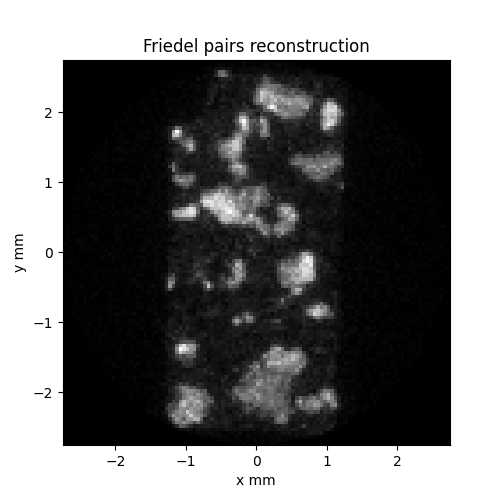

In [59]:
# compute mask for quartz. select_tth_rings returns a mask with all peaks within a certain distance of theoretical tth rings for quartz.
# see doctstring for more info.
mask_qtz = utils.select_tth_rings(cf_paired, phase_dict['quartz'].strong_peaks[0], tth_tol=0.02, tth_max=15, is_sorted=False)

kw = {'cmap':'Greys_r'}   # keyword arguments to pass to plot function

# plot reconstruction for quartz peaks only
utils.friedel_recon(cf_paired,
                    xbins = ds.ybinedges,
                    ybins = ds.ybinedges,
                    doplot=True,
                    mask = mask_qtz,
                    weight_by_intensity=True,
                    norm = True,
                    **kw );

We clearly see the quartz grains appearing, but there is still some background signal from outside of these grains. This results either from dodgy Friedel pairs which were wrongly relocated, or from overlaps between different Bragg peaks from different phases, which inevitably results in wrong selection of some peaks. In the next tutorial, we will see how we can improve that and make a better phase map. 

### Save peakfile

To finish, we need to save these data. We will create a new peakfile "datasetname_pks_p.h5", to avoid overwriting the raw peak file

There is a function in ImageD11.columnfile to export columnfiles, but we will use here the custom function from the pf_3dxrd.utils module, which does basically the same but make sure that essential information (namely, fp_id and fp_dist) are saved. 

In [94]:
# save data. The 'minimal' save mode means that only the necessary data columns are kept. All data that can be recomputed from other columns are dropped.
utils.colf_to_hdf(cf_paired, os.path.join(data_dir, dsname+'_pks_p.h5'), save_mode='minimal')